[Pyspark blog](https://bryancutler.github.io/)

[ML w/ Pyspark](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

[GitHub event types](https://developer.github.com/v3/activity/events/types/)

[Churn modeling](https://www.urbanairship.com/blog/churn-prediction-our-machine-learning-model)

[Interpreting Trees](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Binarizer#, OneHotEncoderEstimator, StringIndexer
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import helper as h

In [2]:
churn_data = h.get_merged_data('classification')
cols = churn_data.columns

churn_data.head()

% of users dropped 4.698526359485271


Row(login='0loky0', followers_count=0, following_count=1, blog=0, company=0, created_at='2011-05-24 20:15:25+00:00', public_repos_count=7, public_gists_count=0, hireable=1, updated_at='2019-01-09 15:03:59+00:00', time_between_first_last_event='10 days 15:29:06.000000000', last_event='2016-04-15 10:14:03 UTC', first_event='2016-04-04 18:44:57 UTC', frequency=19, second_period_event_count=0, CommitCommentEvent_count=0, CreateEvent_count=5, DeleteEvent_count=0, ForkEvent_count=2, GollumEvent_count=0, IssueCommentEvent_count=0, IssuesEvent_count=0, MemberEvent_count=0, PublicEvent_count=0, PullRequestEvent_count=0, PullRequestReviewCommentEvent_count=0, PushEvent_count=12, ReleaseEvent_count=0, WatchEvent_count=0)

In [3]:
model_name = 'non-company'
churn_data = churn_data.filter(churn_data.company == 0) 

In [4]:
numeric_features = [t[0] for t in churn_data.dtypes if t[1] == 'int']
churn_data.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
followers_count,155008,2.5844988645747318,22.995471039659716,0,4165
following_count,155008,2.8045649256812553,48.1286594864902,0,17459
blog,155008,0.09908520850536746,0.29877735164008856,0,1
company,155008,0.0,0.0,0,0
public_repos_count,154982,9.4404446968035,25.536300254234458,0,2196
public_gists_count,155007,0.8390395272471566,5.80077422102648,0,539
hireable,155008,0.07200273534269198,0.25849327363099517,0,1
frequency,155008,18.439390225020645,28.653820696777945,2,199
second_period_event_count,155008,11.456363542526837,26.10196329973185,0,199


In [5]:
numeric_features.remove('second_period_event_count')
numeric_features.remove('frequency')
print(numeric_features)

['followers_count', 'following_count', 'blog', 'company', 'public_repos_count', 'public_gists_count', 'hireable', 'CommitCommentEvent_count', 'CreateEvent_count', 'DeleteEvent_count', 'ForkEvent_count', 'GollumEvent_count', 'IssueCommentEvent_count', 'IssuesEvent_count', 'MemberEvent_count', 'PublicEvent_count', 'PullRequestEvent_count', 'PullRequestReviewCommentEvent_count', 'PushEvent_count', 'ReleaseEvent_count', 'WatchEvent_count']


## Build PySpark pipeline

In [6]:
stages = []
# binarizer needs double type or it throws an error.
churn_data = churn_data.withColumn("second_period_event_count", 
                                   churn_data.second_period_event_count.cast(DoubleType()))
binarizer = Binarizer(threshold=0.5, 
                      inputCol="second_period_event_count", 
                      outputCol="label")

stages += [binarizer]
assembler = VectorAssembler(inputCols=numeric_features, 
                            outputCol="features").setHandleInvalid("skip")
stages += [assembler]

In [7]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(churn_data)
churn_data = pipelineModel.transform(churn_data)
selectedCols = ['label', 'features'] + cols
churn_data = churn_data.select(selectedCols)
churn_data.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- login: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- blog: integer (nullable = true)
 |-- company: integer (nullable = true)
 |-- created_at: string (nullable = true)
 |-- public_repos_count: integer (nullable = true)
 |-- public_gists_count: integer (nullable = true)
 |-- hireable: integer (nullable = true)
 |-- updated_at: string (nullable = true)
 |-- time_between_first_last_event: string (nullable = true)
 |-- last_event: string (nullable = true)
 |-- first_event: string (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- second_period_event_count: double (nullable = true)
 |-- CommitCommentEvent_count: integer (nullable = true)
 |-- CreateEvent_count: integer (nullable = true)
 |-- DeleteEvent_count: integer (nullable = true)
 |-- ForkEvent_count: integer (nullable = true)
 |-- GollumEvent_count: integer

In [8]:
# save pipeline
pipeline.write().overwrite().save('pipeline')

In [9]:
examples = pd.DataFrame(churn_data.take(5), columns=churn_data.columns).transpose()
examples

,0,1,2,3,4
label,0,1,1,1,0
features,"(0.0, 1.0, 0.0, 0.0, 7.0, 0.0, 1.0, 0.0, 5.0, ...","(0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2.0, 6.0, 0.0, 0.0, 35.0, 0.0, 0.0, 0.0, 0.0,...","(1.0, 28.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
login,0loky0,13246864965,1xPdd,2582056905xy,277542952
followers_count,0,0,0,2,1
following_count,1,0,0,6,28
blog,0,0,0,0,0
company,0,0,0,0,0
created_at,2011-05-24 20:15:25+00:00,2016-04-14 10:04:50+00:00,2014-07-11 03:45:56+00:00,2014-04-24 14:51:26+00:00,2016-03-16 03:17:58+00:00
public_repos_count,7,3,0,35,1
public_gists_count,0,0,0,0,0


### Training/Test split

In [10]:
train, test = churn_data.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: {0}".format(train.count()))
print("Test Dataset Count: {0}".format(test.count()))

Training Dataset Count: 108383
Test Dataset Count: 46599


## Logistic Regression

In [11]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)#,
                       #regParam=0.03, elasticNetParam=0.8)
lrModel = lr.fit(train)

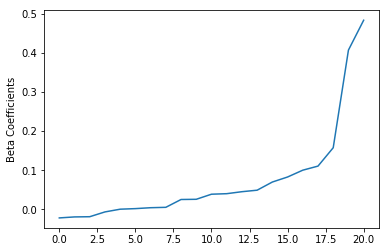

Param(parent='LogisticRegression_25d6234ed9b4', name='featuresCol', doc='features column name')

In [12]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
lrModel.featuresCol

In [13]:
pd.DataFrame({'features': numeric_features, 
              'weights': lrModel.coefficients.values}
            ).sort_values(by='weights', ascending=False)


,features,weights
2,blog,0.484161
6,hireable,0.407648
20,WatchEvent_count,0.157497
12,IssueCommentEvent_count,0.110426
19,ReleaseEvent_count,0.099967
4,public_repos_count,0.082485
15,PublicEvent_count,0.069610
5,public_gists_count,0.048683
1,following_count,0.044815
0,followers_count,0.039735


Training set areaUnderROC: 0.8451602430168963


/home/brian/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


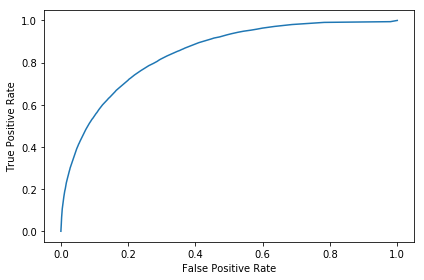

In [14]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)

ax.plot(roc['FPR'],roc['TPR'])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
#ax.title('ROC Curve')
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


fig.savefig('figures/logistic_regression_ROC.png')

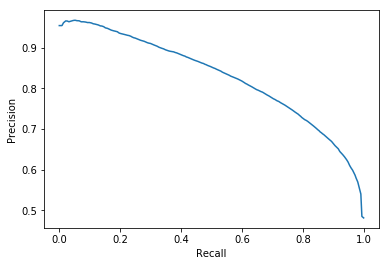

In [15]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [16]:
#lrModel._java_obj.setThreshold(0.5)
print('Threshold: {0}'.format(lrModel._java_obj.getThreshold()))
predictions = lrModel.transform(test)
show_cols = ['followers_count', 'company', 'blog', 
             'label', 'rawPrediction', 'prediction', 'probability']
predictions.select(show_cols).show(50)

Threshold: 0.5
+---------------+-------+----+-----+--------------------+----------+--------------------+
|followers_count|company|blog|label|       rawPrediction|prediction|         probability|
+---------------+-------+----+-----+--------------------+----------+--------------------+
|              1|      0|   1|  0.0|[-1.4794773974026...|       1.0|[0.18550636830464...|
|              1|      0|   1|  0.0|[0.07018217060716...|       0.0|[0.51753834442888...|
|             10|      0|   0|  0.0|[-4.2364958480770...|       1.0|[0.01425210744656...|
|              1|      0|   0|  0.0|[0.34768481926705...|       0.0|[0.58605604126325...|
|              5|      0|   0|  0.0|[-1.1095205164078...|       1.0|[0.24796028992958...|
|              1|      0|   0|  0.0|[-0.6860363389589...|       1.0|[0.33491538864697...|
|              2|      0|   0|  0.0|[0.76419297678666...|       0.0|[0.68226338139134...|
|              2|      0|   0|  0.0|[-1.1930406310034...|       1.0|[0.23271556246246

In [21]:
h.eval_metrics(predictions)

Precision: 0.815
Recall:    0.61
Accuracy:  0.748
F1-score:  0.6982


In [ ]:
lrModel.write().overwrite().save('lrModel_' + model_name)

In [ ]:
#testM = LogisticRegressionModel.load("lrModel" + model_name)
#predictions = testM.transform(test)

## Random forest classification

In [ ]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)

In [ ]:
h.write_tree_to_file(rfModel.toDebugString, 'rf_trees_' + model_name)

In [ ]:
predictions = rfModel.transform(test)
predictions.select(show_cols).show(50)

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(
    predictions, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
h.eval_metrics(predictions)

## Gradient Boosted Trees

[Gradient Boost vs XGboost](https://datascience.stackexchange.com/questions/16904/gbm-vs-xgboost-key-differences)

In [ ]:
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)

In [ ]:
h.write_tree_to_file(gbtModel.toDebugString, 'gbt_trees_' + model_name)

In [ ]:
predictions = gbtModel.transform(test)
predictions.select(show_cols).show(50)

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(
    evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
h.eval_metrics(predictions)

## Grid search with cross validation

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)